In [3]:
import Pkg
using Optim
using PyPlot
using LinearAlgebra
using FFTW

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [5]:
#https://stackoverflow.com/questions/56030394/how-to-visualize-fft-of-a-signal-in-julia

In [6]:
function lf(p,l)
    n = length(p)
    pt = fft(p)
    for i=1:n
        if mod(i,l) !=0
            pt[i] =0
        end
    end
    pt = abs.(pt)
    return pt.*(pt.<=n)
end


lf([1,2,3,4,5,6],2)

6-element Array{Float64,1}:
 0.0
 6.0
 0.0
 3.0
 0.0
 6.0

In [20]:
function lf(p,l,m)
    n = length(p)
    
    #only even frequencies
    zfl = fft(p)
    #println(zfl)
    for i=0:(n-1)
        if mod(i,m) !=0
            #println(i)
            zfl[i+1] =0
        end
    end
    
    #los pass filter as well
    zfl = reinterpret(Float64, zfl)
    zre = @view zfl[1:2:end-1]
    zim = @view zfl[2:2:end]
    zre[n-l+1:n] = zeros(l)
    zim[n-l+1:n] = zeros(l)
    result = (zre.+1im*zim)
    
    return reinterpret(Float64, ifft(result))[1:2:end-1]
end

ifft(lf([1,2,3,4,5,6],2,3))

6-element Array{Complex{Float64},1}:
  3.5 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im
 -0.5 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im

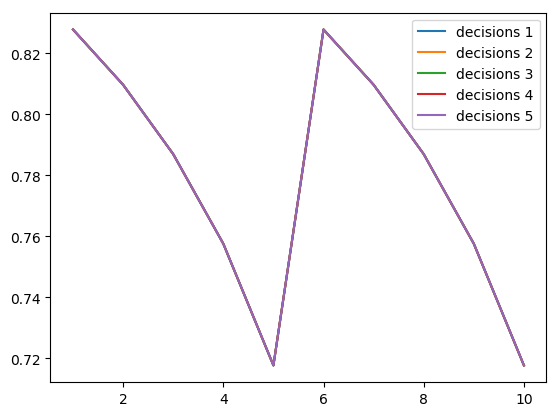

[0.827733, 0.809638, 0.786941, 0.757582, 0.717705, 0.827733, 0.809638, 0.786941, 0.757582, 0.717705]
Complex{Float64}[7.7992+0.0im, 0.0+0.0im, 0.100325-0.209381im, 0.0+0.0im, 0.13874-0.0522286im, 0.0+0.0im, 0.13874+0.0522286im, 0.0+0.0im, 0.100325+0.209381im, 0.0+0.0im]
-----
[0.827749, 0.809646, 0.786934, 0.757569, 0.717721, 0.827749, 0.809646, 0.786934, 0.757569, 0.717721]
Complex{Float64}[7.79924+0.0im, 0.0+0.0im, 0.100403-0.209372im, 0.0+0.0im, 0.138721-0.0522094im, 0.0+0.0im, 0.138721+0.0522094im, 0.0+0.0im, 0.100403+0.209372im, 0.0+0.0im]
-----
[0.827749, 0.809646, 0.786934, 0.757569, 0.717721, 0.827749, 0.809646, 0.786934, 0.757569, 0.717721]
Complex{Float64}[7.79924+0.0im, 0.0+0.0im, 0.100403-0.209372im, 0.0+0.0im, 0.138721-0.0522094im, 0.0+0.0im, 0.138721+0.0522094im, 0.0+0.0im, 0.100403+0.209372im, 0.0+0.0im]
-----
[0.827764, 0.809663, 0.786922, 0.757583, 0.717751, 0.827764, 0.809663, 0.786922, 0.757583, 0.717751]
Complex{Float64}[7.79937+0.0im, 0.0+0.0im, 0.100459-0.209317im

In [22]:
function no_win(p,g)
    l = length(p)
    gs = reverse(g(p))
    result = ones(l)
    for i = 2:l
        for j=i:l
            result[i-1] = result[i-1]*gs[j]
        end
    end
    return reverse(result)
end

function create_obj(u,g)
    obj(p) = -1*u(p,g)
    return obj
end


function create_plot(n,l,u,g)
    p0 = 0.5*ones(n)
    for i=1:l
        obj(p) = create_obj(u,g)(p)
        obj_avg(p) = obj(lf(p,i,2))
        res = optimize(obj_avg,p0)
        ps = lf( res.minimizer, i,2 )
        println(ps)
        println(fft(ps))
        println("-----")
        xs = collect( 1:length(ps) )
        plot(xs, ps, label="decisions $(i)")
    end
    legend()
    show()
end

BETA = 1

f1(p) = clamp!(p, 0, 1)
u1(p,g) = p.*(ones(size(p)) - g(p)).*no_win(p,g)
u2(p,g) = sum((BETA*ones(length(p))).^collect(1:length(p)) .*u1(p,g))

create_plot(10,5,u2,f1)